# Multivariate Time Series Generation - Presence Disclosure with Euclidean Distance

This script runs a membership inference attack on our model to assess
presence disclosure and the ability of our Model to preserve underlying data privacy. Euclidean is used as the distance metric



## If Using Google Colabs

Mount your drive if you are running this on Colabs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Directories

In [ ]:
import os
os.chdir('/content/drive/My Drive/Multivariate-timeseries-GANs/')

data_dir = './Data'
results_dir = './Results/Training'

## Import Dependencies

In [ ]:
import torch

import pandas as pd
import numpy as np
import json as js

from matplotlib import pyplot as plt
from scipy.spatial import distance
from tqdm import tqdm

For plotting later

In [ ]:
# Colour Blind Friendly Colours
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

## GPU

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
  cuda = True
  print('Using: ' +str(torch.cuda.get_device_name(device)))
else:
  cuda = False
  print('Using: CPU')

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Using: Tesla T4


## Function Definitions

In [ ]:
def load_params(filename):
    with open(filename, 'r') as f:
        param_dict = js.load(f)
    
    return param_dict


def load_data(filename):
    mv_data = torch.load(filename)
    if len(mv_data[0,:,0]) == 188:
        mv_data = mv_data[:, :-1, :] 
    
    return mv_data 

def load_gen_data(filename):
  gen_data = torch.load(filename)

  return gen_data

In [ ]:
def mia(train_0, train_1, test_0, test_1, gen_0, gen_1, results_dir):

  sample_size = np.arange(1000,11000,1000)
  cutoff = [0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7]
  idx = 0

  fig, ax = plt.subplots(1,2,constrained_layout=True, figsize=(8,4))
  colour = ['red','blue','green','orange','magenta','cyan','black','yellow']

  pre = []
  rec = []
  for c in tqdm(cutoff):
      precision = []
      recall = []
      for r in tqdm(sample_size):
          
          train_sample_0 = train_0.sample(r)
          train_labels_0 = np.zeros((r,1)) # training flag
          test_sample_0 = test_0.sample(r)
          test_labels_0 = np.ones((r,1)) # training flag

          sample_0 = pd.concat([train_sample_0,test_sample_0]).reset_index(drop=True)
          sample_0 = sample_0.values

          labels_0 = np.concatenate([train_labels_0,test_labels_0])
          
          train_sample_1 = train_1.sample(r)
          train_labels_1 = np.zeros((r,1)) # training flag
          test_sample_1 = test_1.sample(r)
          test_labels_1 = np.ones((r,1)) # training flag

          sample_1 = pd.concat([train_sample_1,test_sample_1]).reset_index(drop=True)
          sample_1 = sample_1.values

          labels_1 = np.concatenate([train_labels_1,test_labels_1])
          
          Y_0 = distance.cdist(sample_0, gen_0, 'euclidean')
          Y_1 = distance.cdist(sample_1, gen_1, 'euclidean')
          print(Y_0.shape)
          
          Y = [sum(x) for x in zip(Y_0, Y_1)]
          Y = np.asarray(Y)
          print(Y.shape)
          
          mean = np.asscalar(Y.mean())
          threshold = c*mean 

          print("Mean Distance: "+str(mean)+", Sample Size: "+str(2*r)+", Cutoff Fraction: "+str(c)+", Threshold: "+str(threshold))

          min_Y = np.amin(Y, axis = 1)


          match = labels_0[min_Y <= threshold] + labels_1[min_Y <= threshold]
          diff = labels_0[min_Y > threshold] + labels_1[min_Y > threshold]
          print(match.shape, diff.shape)

          TP = (match == 0).sum()
          FP = (match == 1).sum()
          TN = (diff == 1).sum()
          FN = (diff == 0).sum()
          print(TP,FP, TN, FN) 


          if TP+FN == 0:
              recall.append(None)
          else:
              recall.append(TP/(TP+FN))
          if TP+FP == 0:
              precision.append(None)
          else:
              precision.append( TP/(TP+FP))


      ax[1].plot(sample_size, recall, label = (str(c)+"*mean"),linestyle='solid', marker='o', color = colour[idx])
      ax[0].plot(sample_size, precision,  label = str(c)+"*mean", linestyle='solid',marker='o',  color = colour[idx])
      idx = idx+1
      pre.append(precision)
      rec.append(recall)


  fig.suptitle("Precision and Recall vs. Sample Size", size = 'large')
  ax[1].set_ylim([-0.1, 1.1])
  ax[1].set_yticks([0,0.5,1])
  ax[1].set_xlabel("r", size = 'medium')
  ax[1].set_ylabel("Recall", size = 'medium')


  ax[1].legend(title = 'ε',  fontsize = 'small')
  ax[0].set_ylim([-0.1, 1.1])
  ax[0].set_yticks([0,0.5, 1])
  ax[0].set_xlabel("r", size = 'medium')
  ax[0].set_ylabel("Precision", size = 'medium')

  for k in range(0,2):
      for tick in ax[k].xaxis.get_major_ticks():
          tick.label.set_fontsize(12)
      for tick in ax[k].yaxis.get_major_ticks():
          tick.label.set_fontsize(12)

  #fig.savefig(results_dir+'/Precision_Disclosure.pdf',format="pdf")    
  plt.show(fig)

## Setup for main loop

In [ ]:
# These are the names I used for my training results directories 

directories = ['LSGAN_Training', 'LSGAN_ARR_Training',
               'LSGAN_DTW_Training', 'LSGAN_DTW_ARR_Training',
               'DTWGAN_Training', 'DTWGAN_ARR_Training',
               'Loss-SenseGAN', 'Loss-SenseGAN_Arr',
               'LS-GAN_DTW', 'LS-GAN_DTW_ARR']

files = ['nsr_clf.pt', 'arr_clf.pt',
         'nsr_clf.pt', 'arr_clf.pt',
         'nsr_clf.pt', 'arr_clf.pt',
         'nsr_clf.pt', 'arr_clf.pt',
         'arr_clf.pt']

# Load Parameters
params = load_params(results_dir+'/parameters.json')
# Load Data
data = load_data('./'+data_dir+'/'+params['data'])

# Load some generated data - 
## can implement for loop here if needs be
i = 0

#Load generated data
gen_data = torch.load('./Results/'+directories[i]+'/'+files[i])

# Index for data selection 
# in presence disclosure
train_ind = 10000
test_ind = 10000
ind = 20000

# This is broken down into two single leads but can be used as 
## multiple leads using the DTW functions from the other notebooks
# Lead I
train_data_0  = pd.DataFrame(data[:train_ind,:,0].detach().cpu().numpy())
test_data_0   = pd.DataFrame(data[ind:ind+test_ind,:,0].detach().cpu().numpy())
gen_data_0   = pd.DataFrame(gen_data[:,:,0].detach().cpu().numpy())

# Lead II
train_data_1  = pd.DataFrame(data[:train_ind,:,1].detach().cpu().numpy())
test_data_1   = pd.DataFrame(data[ind:ind+test_ind,:,1].detach().cpu().numpy())
gen_data_1   = pd.DataFrame(gen_data[:,:,1].detach().cpu().numpy())

gen_0 = gen_data_0.values
gen_1 = gen_data_1.values

Data_Shape: torch.Size([30197, 500, 2])
torch.Size([200, 500, 2])


## Membership Inference Attack

Here the membership attack is called. I will be implementing the R Multivariate DTW package shorlty, it can be readily taken implemented from the other Notebooks in this repo.

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

 10%|█         | 1/10 [00:00<00:02,  3.16it/s]

(2000, 200)
(2000, 200)
Mean Distance: 4.491063834301313, Sample Size: 2000, Cutoff Fraction: 0.05, Threshold: 0.22455319171506566
(0, 1) (2000, 1)
0 0 0 1000



 20%|██        | 2/10 [00:00<00:03,  2.44it/s]

(4000, 200)
(4000, 200)
Mean Distance: 4.498616528984835, Sample Size: 4000, Cutoff Fraction: 0.05, Threshold: 0.22493082644924176
(0, 1) (4000, 1)
0 0 0 2000



 30%|███       | 3/10 [00:01<00:03,  1.76it/s]

(6000, 200)
(6000, 200)
Mean Distance: 4.4938825971233385, Sample Size: 6000, Cutoff Fraction: 0.05, Threshold: 0.22469412985616694
(0, 1) (6000, 1)
0 0 0 3000



 40%|████      | 4/10 [00:03<00:04,  1.30it/s]

(8000, 200)
(8000, 200)
Mean Distance: 4.495231863675871, Sample Size: 8000, Cutoff Fraction: 0.05, Threshold: 0.22476159318379355
(0, 1) (8000, 1)
0 0 0 4000



 50%|█████     | 5/10 [00:04<00:05,  1.01s/it]

(10000, 200)
(10000, 200)
Mean Distance: 4.4937276245012825, Sample Size: 10000, Cutoff Fraction: 0.05, Threshold: 0.22468638122506412
(0, 1) (10000, 1)
0 0 0 5000



 60%|██████    | 6/10 [00:06<00:05,  1.27s/it]

(12000, 200)
(12000, 200)
Mean Distance: 4.492974492238442, Sample Size: 12000, Cutoff Fraction: 0.05, Threshold: 0.22464872461192212
(0, 1) (12000, 1)
0 0 0 6000



 70%|███████   | 7/10 [00:08<00:04,  1.54s/it]

(14000, 200)
(14000, 200)
Mean Distance: 4.493364153955035, Sample Size: 14000, Cutoff Fraction: 0.05, Threshold: 0.22466820769775175
(0, 1) (14000, 1)
0 0 0 7000



 80%|████████  | 8/10 [00:11<00:03,  1.82s/it]

(16000, 200)
(16000, 200)
Mean Distance: 4.493790955043303, Sample Size: 16000, Cutoff Fraction: 0.05, Threshold: 0.22468954775216515
(0, 1) (16000, 1)
0 0 0 8000



 90%|█████████ | 9/10 [00:13<00:02,  2.10s/it]

(18000, 200)
(18000, 200)
Mean Distance: 4.493859971806168, Sample Size: 18000, Cutoff Fraction: 0.05, Threshold: 0.2246929985903084
(0, 1) (18000, 1)
0 0 0 9000



  0%|          | 0/10 [00:00<?, ?it/s]

(20000, 200)
(20000, 200)
Mean Distance: 4.493554035574755, Sample Size: 20000, Cutoff Fraction: 0.05, Threshold: 0.22467770177873778
(0, 1) (20000, 1)
0 0 0 10000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

 10%|█         | 1/10 [00:00<00:02,  3.17it/s]

(2000, 200)
(2000, 200)
Mean Distance: 4.493530443833883, Sample Size: 2000, Cutoff Fraction: 0.1, Threshold: 0.44935304438338836
(0, 1) (2000, 1)
0 0 0 1000



 20%|██        | 2/10 [00:00<00:03,  2.43it/s]

(4000, 200)
(4000, 200)
Mean Distance: 4.4925635806012165, Sample Size: 4000, Cutoff Fraction: 0.1, Threshold: 0.44925635806012165
(0, 1) (4000, 1)
0 0 0 2000



 30%|███       | 3/10 [00:01<00:04,  1.75it/s]

(6000, 200)
(6000, 200)
Mean Distance: 4.491933225679685, Sample Size: 6000, Cutoff Fraction: 0.1, Threshold: 0.4491933225679685
(0, 1) (6000, 1)
0 0 0 3000



 40%|████      | 4/10 [00:03<00:04,  1.29it/s]

(8000, 200)
(8000, 200)
Mean Distance: 4.493275596854193, Sample Size: 8000, Cutoff Fraction: 0.1, Threshold: 0.4493275596854194
(0, 1) (8000, 1)
0 0 0 4000



 50%|█████     | 5/10 [00:04<00:05,  1.01s/it]

(10000, 200)
(10000, 200)
Mean Distance: 4.492538740988797, Sample Size: 10000, Cutoff Fraction: 0.1, Threshold: 0.44925387409887974
(0, 1) (10000, 1)
0 0 0 5000



 60%|██████    | 6/10 [00:06<00:05,  1.27s/it]

(12000, 200)
(12000, 200)
Mean Distance: 4.495037989788562, Sample Size: 12000, Cutoff Fraction: 0.1, Threshold: 0.44950379897885623
(0, 1) (12000, 1)
0 0 0 6000



 70%|███████   | 7/10 [00:08<00:04,  1.54s/it]

(14000, 200)
(14000, 200)
Mean Distance: 4.493018615023618, Sample Size: 14000, Cutoff Fraction: 0.1, Threshold: 0.44930186150236184
(0, 1) (14000, 1)
0 0 0 7000



 80%|████████  | 8/10 [00:11<00:03,  1.82s/it]

(16000, 200)
(16000, 200)
Mean Distance: 4.493046030354321, Sample Size: 16000, Cutoff Fraction: 0.1, Threshold: 0.4493046030354322
(0, 1) (16000, 1)
0 0 0 8000



 90%|█████████ | 9/10 [00:13<00:02,  2.11s/it]

(18000, 200)
(18000, 200)
Mean Distance: 4.4935605834698364, Sample Size: 18000, Cutoff Fraction: 0.1, Threshold: 0.44935605834698367
(0, 1) (18000, 1)
0 0 0 9000



  0%|          | 0/10 [00:00<?, ?it/s]

(20000, 200)
(20000, 200)
Mean Distance: 4.493554035574759, Sample Size: 20000, Cutoff Fraction: 0.1, Threshold: 0.4493554035574759
(0, 1) (20000, 1)
0 0 0 10000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

 10%|█         | 1/10 [00:00<00:02,  3.22it/s]

(2000, 200)
(2000, 200)
Mean Distance: 4.4890498801110965, Sample Size: 2000, Cutoff Fraction: 0.2, Threshold: 0.8978099760222193
(0, 1) (2000, 1)
0 0 0 1000



 20%|██        | 2/10 [00:00<00:03,  2.48it/s]

(4000, 200)
(4000, 200)
Mean Distance: 4.494047826003488, Sample Size: 4000, Cutoff Fraction: 0.2, Threshold: 0.8988095652006977
(0, 1) (4000, 1)
0 0 0 2000



 30%|███       | 3/10 [00:01<00:03,  1.78it/s]

(6000, 200)
(6000, 200)
Mean Distance: 4.492939408268857, Sample Size: 6000, Cutoff Fraction: 0.2, Threshold: 0.8985878816537713
(0, 1) (6000, 1)
0 0 0 3000



 40%|████      | 4/10 [00:03<00:04,  1.30it/s]

(8000, 200)
(8000, 200)
Mean Distance: 4.494275088244025, Sample Size: 8000, Cutoff Fraction: 0.2, Threshold: 0.8988550176488052
(0, 1) (8000, 1)
0 0 0 4000



 50%|█████     | 5/10 [00:04<00:04,  1.00it/s]

(10000, 200)
(10000, 200)
Mean Distance: 4.493138243861436, Sample Size: 10000, Cutoff Fraction: 0.2, Threshold: 0.8986276487722873
(0, 1) (10000, 1)
0 0 0 5000



 60%|██████    | 6/10 [00:06<00:05,  1.26s/it]

(12000, 200)
(12000, 200)
Mean Distance: 4.491992574358972, Sample Size: 12000, Cutoff Fraction: 0.2, Threshold: 0.8983985148717943
(0, 1) (12000, 1)
0 0 0 6000



 70%|███████   | 7/10 [00:08<00:04,  1.53s/it]

(14000, 200)
(14000, 200)
Mean Distance: 4.4947175353867035, Sample Size: 14000, Cutoff Fraction: 0.2, Threshold: 0.8989435070773407
(0, 1) (14000, 1)
0 0 0 7000



 80%|████████  | 8/10 [00:11<00:03,  1.82s/it]

(16000, 200)
(16000, 200)
Mean Distance: 4.4933799749451815, Sample Size: 16000, Cutoff Fraction: 0.2, Threshold: 0.8986759949890364
(0, 1) (16000, 1)
0 0 0 8000



 90%|█████████ | 9/10 [00:13<00:02,  2.11s/it]

(18000, 200)
(18000, 200)
Mean Distance: 4.49352100102131, Sample Size: 18000, Cutoff Fraction: 0.2, Threshold: 0.898704200204262
(0, 1) (18000, 1)
0 0 0 9000



  0%|          | 0/10 [00:00<?, ?it/s]

(20000, 200)
(20000, 200)
Mean Distance: 4.493554035574753, Sample Size: 20000, Cutoff Fraction: 0.2, Threshold: 0.8987108071149508
(0, 1) (20000, 1)
0 0 0 10000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

 10%|█         | 1/10 [00:00<00:02,  3.17it/s]

(2000, 200)
(2000, 200)
Mean Distance: 4.494898244005647, Sample Size: 2000, Cutoff Fraction: 0.3, Threshold: 1.348469473201694
(0, 1) (2000, 1)
0 0 0 1000



 20%|██        | 2/10 [00:00<00:03,  2.45it/s]

(4000, 200)
(4000, 200)
Mean Distance: 4.494366083303087, Sample Size: 4000, Cutoff Fraction: 0.3, Threshold: 1.3483098249909262
(0, 1) (4000, 1)
0 0 0 2000



 30%|███       | 3/10 [00:01<00:03,  1.76it/s]

(6000, 200)
(6000, 200)
Mean Distance: 4.492165241226259, Sample Size: 6000, Cutoff Fraction: 0.3, Threshold: 1.3476495723678779
(0, 1) (6000, 1)
0 0 0 3000



 40%|████      | 4/10 [00:03<00:04,  1.28it/s]

(8000, 200)
(8000, 200)
Mean Distance: 4.492796897488918, Sample Size: 8000, Cutoff Fraction: 0.3, Threshold: 1.3478390692466753
(0, 1) (8000, 1)
0 0 0 4000



 50%|█████     | 5/10 [00:04<00:05,  1.02s/it]

(10000, 200)
(10000, 200)
Mean Distance: 4.49321367934393, Sample Size: 10000, Cutoff Fraction: 0.3, Threshold: 1.347964103803179
(0, 1) (10000, 1)
0 0 0 5000



 60%|██████    | 6/10 [00:06<00:05,  1.28s/it]

(12000, 200)
(12000, 200)
Mean Distance: 4.4939076581548285, Sample Size: 12000, Cutoff Fraction: 0.3, Threshold: 1.3481722974464485
(0, 1) (12000, 1)
0 0 0 6000



 70%|███████   | 7/10 [00:08<00:04,  1.56s/it]

(14000, 200)
(14000, 200)
Mean Distance: 4.495056073349461, Sample Size: 14000, Cutoff Fraction: 0.3, Threshold: 1.3485168220048382
(0, 1) (14000, 1)
0 0 0 7000



 80%|████████  | 8/10 [00:11<00:03,  1.85s/it]

(16000, 200)
(16000, 200)
Mean Distance: 4.493774897580876, Sample Size: 16000, Cutoff Fraction: 0.3, Threshold: 1.3481324692742627
(0, 1) (16000, 1)
0 0 0 8000



 90%|█████████ | 9/10 [00:14<00:02,  2.13s/it]

(18000, 200)
(18000, 200)
Mean Distance: 4.493442032968547, Sample Size: 18000, Cutoff Fraction: 0.3, Threshold: 1.348032609890564
(0, 1) (18000, 1)
0 0 0 9000



  0%|          | 0/10 [00:00<?, ?it/s]

(20000, 200)
(20000, 200)
Mean Distance: 4.493554035574758, Sample Size: 20000, Cutoff Fraction: 0.3, Threshold: 1.3480662106724273
(0, 1) (20000, 1)
0 0 0 10000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

 10%|█         | 1/10 [00:00<00:02,  3.17it/s]

(2000, 200)
(2000, 200)
Mean Distance: 4.48720716772082, Sample Size: 2000, Cutoff Fraction: 0.4, Threshold: 1.7948828670883281
(0, 1) (2000, 1)
0 0 0 1000



 20%|██        | 2/10 [00:00<00:03,  2.48it/s]

(4000, 200)
(4000, 200)
Mean Distance: 4.491615716272365, Sample Size: 4000, Cutoff Fraction: 0.4, Threshold: 1.7966462865089463
(0, 1) (4000, 1)
0 0 0 2000



 30%|███       | 3/10 [00:01<00:03,  1.78it/s]

(6000, 200)
(6000, 200)
Mean Distance: 4.493612229399517, Sample Size: 6000, Cutoff Fraction: 0.4, Threshold: 1.797444891759807
(0, 1) (6000, 1)
0 0 0 3000



 40%|████      | 4/10 [00:03<00:04,  1.30it/s]

(8000, 200)
(8000, 200)
Mean Distance: 4.4944809010930316, Sample Size: 8000, Cutoff Fraction: 0.4, Threshold: 1.7977923604372128
(0, 1) (8000, 1)
0 0 0 4000



 50%|█████     | 5/10 [00:04<00:04,  1.00it/s]

(10000, 200)
(10000, 200)
Mean Distance: 4.4915875682571, Sample Size: 10000, Cutoff Fraction: 0.4, Threshold: 1.7966350273028402
(0, 1) (10000, 1)
0 0 0 5000



 60%|██████    | 6/10 [00:06<00:05,  1.26s/it]

(12000, 200)
(12000, 200)
Mean Distance: 4.493445532327405, Sample Size: 12000, Cutoff Fraction: 0.4, Threshold: 1.797378212930962
(0, 1) (12000, 1)
0 0 0 6000



 70%|███████   | 7/10 [00:08<00:04,  1.53s/it]

(14000, 200)
(14000, 200)
Mean Distance: 4.493215097813146, Sample Size: 14000, Cutoff Fraction: 0.4, Threshold: 1.7972860391252585
(0, 1) (14000, 1)
0 0 0 7000



 80%|████████  | 8/10 [00:11<00:03,  1.83s/it]

(16000, 200)
(16000, 200)
Mean Distance: 4.493663445510064, Sample Size: 16000, Cutoff Fraction: 0.4, Threshold: 1.7974653782040257
(0, 1) (16000, 1)
0 0 0 8000



 90%|█████████ | 9/10 [00:14<00:02,  2.12s/it]

(18000, 200)
(18000, 200)
Mean Distance: 4.493370161087595, Sample Size: 18000, Cutoff Fraction: 0.4, Threshold: 1.7973480644350381
(0, 1) (18000, 1)
0 0 0 9000



  0%|          | 0/10 [00:00<?, ?it/s]

(20000, 200)
(20000, 200)
Mean Distance: 4.493554035574757, Sample Size: 20000, Cutoff Fraction: 0.4, Threshold: 1.7974216142299029
(0, 1) (20000, 1)
0 0 0 10000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

 10%|█         | 1/10 [00:00<00:02,  3.20it/s]

(2000, 200)
(2000, 200)
Mean Distance: 4.491740168238312, Sample Size: 2000, Cutoff Fraction: 0.5, Threshold: 2.245870084119156
(0, 1) (2000, 1)
0 0 0 1000



 20%|██        | 2/10 [00:00<00:03,  2.45it/s]

(4000, 200)
(4000, 200)
Mean Distance: 4.492920451703862, Sample Size: 4000, Cutoff Fraction: 0.5, Threshold: 2.246460225851931
(0, 1) (4000, 1)
0 0 0 2000



 30%|███       | 3/10 [00:01<00:03,  1.77it/s]

(6000, 200)
(6000, 200)
Mean Distance: 4.49516612840756, Sample Size: 6000, Cutoff Fraction: 0.5, Threshold: 2.24758306420378
(0, 1) (6000, 1)
0 0 0 3000



 40%|████      | 4/10 [00:03<00:04,  1.30it/s]

(8000, 200)
(8000, 200)
Mean Distance: 4.4928368081955705, Sample Size: 8000, Cutoff Fraction: 0.5, Threshold: 2.2464184040977853
(0, 1) (8000, 1)
0 0 0 4000



 50%|█████     | 5/10 [00:04<00:05,  1.01s/it]

(10000, 200)
(10000, 200)
Mean Distance: 4.493961169271733, Sample Size: 10000, Cutoff Fraction: 0.5, Threshold: 2.2469805846358666
(0, 1) (10000, 1)
0 0 0 5000



 60%|██████    | 6/10 [00:06<00:05,  1.27s/it]

(12000, 200)
(12000, 200)
Mean Distance: 4.4942968972401065, Sample Size: 12000, Cutoff Fraction: 0.5, Threshold: 2.2471484486200533
(0, 1) (12000, 1)
0 0 0 6000



 70%|███████   | 7/10 [00:08<00:04,  1.54s/it]

(14000, 200)
(14000, 200)
Mean Distance: 4.493592974477796, Sample Size: 14000, Cutoff Fraction: 0.5, Threshold: 2.246796487238898
(0, 1) (14000, 1)
0 0 0 7000



 80%|████████  | 8/10 [00:11<00:03,  1.84s/it]

(16000, 200)
(16000, 200)
Mean Distance: 4.493210854797149, Sample Size: 16000, Cutoff Fraction: 0.5, Threshold: 2.2466054273985745
(0, 1) (16000, 1)
0 0 0 8000



 90%|█████████ | 9/10 [00:14<00:02,  2.13s/it]

(18000, 200)
(18000, 200)
Mean Distance: 4.493438391451293, Sample Size: 18000, Cutoff Fraction: 0.5, Threshold: 2.2467191957256465
(0, 1) (18000, 1)
0 0 0 9000



  0%|          | 0/10 [00:00<?, ?it/s]

(20000, 200)
(20000, 200)
Mean Distance: 4.493554035574755, Sample Size: 20000, Cutoff Fraction: 0.5, Threshold: 2.2467770177873776
(0, 1) (20000, 1)
0 0 0 10000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

 10%|█         | 1/10 [00:00<00:02,  3.18it/s]

(2000, 200)
(2000, 200)
Mean Distance: 4.496214157242092, Sample Size: 2000, Cutoff Fraction: 0.6, Threshold: 2.6977284943452555
(0, 1) (2000, 1)
0 0 0 1000



 20%|██        | 2/10 [00:00<00:03,  2.45it/s]

(4000, 200)
(4000, 200)
Mean Distance: 4.492424808041397, Sample Size: 4000, Cutoff Fraction: 0.6, Threshold: 2.695454884824838
(0, 1) (4000, 1)
0 0 0 2000



 30%|███       | 3/10 [00:01<00:03,  1.76it/s]

(6000, 200)
(6000, 200)
Mean Distance: 4.493808367793672, Sample Size: 6000, Cutoff Fraction: 0.6, Threshold: 2.6962850206762035
(0, 1) (6000, 1)
0 0 0 3000



 40%|████      | 4/10 [00:03<00:04,  1.31it/s]

(8000, 200)
(8000, 200)
Mean Distance: 4.495047830297589, Sample Size: 8000, Cutoff Fraction: 0.6, Threshold: 2.6970286981785536
(0, 1) (8000, 1)
0 0 0 4000



 50%|█████     | 5/10 [00:04<00:05,  1.00s/it]

(10000, 200)
(10000, 200)
Mean Distance: 4.494230304037619, Sample Size: 10000, Cutoff Fraction: 0.6, Threshold: 2.696538182422571
(0, 1) (10000, 1)
0 0 0 5000



 60%|██████    | 6/10 [00:06<00:05,  1.26s/it]

(12000, 200)
(12000, 200)
Mean Distance: 4.492978820866882, Sample Size: 12000, Cutoff Fraction: 0.6, Threshold: 2.695787292520129
(0, 1) (12000, 1)
0 0 0 6000



 70%|███████   | 7/10 [00:08<00:04,  1.53s/it]

(14000, 200)
(14000, 200)
Mean Distance: 4.493358281222911, Sample Size: 14000, Cutoff Fraction: 0.6, Threshold: 2.696014968733747
(0, 1) (14000, 1)
0 0 0 7000



 80%|████████  | 8/10 [00:11<00:03,  1.82s/it]

(16000, 200)
(16000, 200)
Mean Distance: 4.492620877867678, Sample Size: 16000, Cutoff Fraction: 0.6, Threshold: 2.6955725267206065
(0, 1) (16000, 1)
0 0 0 8000



 90%|█████████ | 9/10 [00:13<00:02,  2.11s/it]

(18000, 200)
(18000, 200)
Mean Distance: 4.493167890750154, Sample Size: 18000, Cutoff Fraction: 0.6, Threshold: 2.6959007344500923
(0, 1) (18000, 1)
0 0 0 9000



  0%|          | 0/10 [00:00<?, ?it/s]

(20000, 200)
(20000, 200)
Mean Distance: 4.493554035574759, Sample Size: 20000, Cutoff Fraction: 0.6, Threshold: 2.696132421344855
(0, 1) (20000, 1)
0 0 0 10000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

 10%|█         | 1/10 [00:00<00:02,  3.13it/s]

(2000, 200)
(2000, 200)
Mean Distance: 4.497463622539026, Sample Size: 2000, Cutoff Fraction: 0.7, Threshold: 3.1482245357773184
(0, 1) (2000, 1)
0 0 0 1000



 20%|██        | 2/10 [00:00<00:03,  2.43it/s]

(4000, 200)
(4000, 200)
Mean Distance: 4.494052357304632, Sample Size: 4000, Cutoff Fraction: 0.7, Threshold: 3.1458366501132424
(0, 1) (4000, 1)
0 0 0 2000



 30%|███       | 3/10 [00:01<00:03,  1.76it/s]

(6000, 200)
(6000, 200)
Mean Distance: 4.492012471082766, Sample Size: 6000, Cutoff Fraction: 0.7, Threshold: 3.1444087297579357
(0, 1) (6000, 1)
0 0 0 3000



 40%|████      | 4/10 [00:03<00:04,  1.30it/s]

(8000, 200)
(8000, 200)
Mean Distance: 4.494439573438051, Sample Size: 8000, Cutoff Fraction: 0.7, Threshold: 3.146107701406635
(0, 1) (8000, 1)
0 0 0 4000



 50%|█████     | 5/10 [00:04<00:05,  1.00s/it]

(10000, 200)
(10000, 200)
Mean Distance: 4.491824552212749, Sample Size: 10000, Cutoff Fraction: 0.7, Threshold: 3.144277186548924
(0, 1) (10000, 1)
0 0 0 5000



 60%|██████    | 6/10 [00:06<00:05,  1.25s/it]

(12000, 200)
(12000, 200)
Mean Distance: 4.492774942293987, Sample Size: 12000, Cutoff Fraction: 0.7, Threshold: 3.1449424596057907
(0, 1) (12000, 1)
0 0 0 6000



 70%|███████   | 7/10 [00:08<00:04,  1.52s/it]

(14000, 200)
(14000, 200)
Mean Distance: 4.493650244326909, Sample Size: 14000, Cutoff Fraction: 0.7, Threshold: 3.145555171028836
(0, 1) (14000, 1)
0 0 0 7000



 80%|████████  | 8/10 [00:11<00:03,  1.80s/it]

(16000, 200)
(16000, 200)
Mean Distance: 4.493564838575671, Sample Size: 16000, Cutoff Fraction: 0.7, Threshold: 3.1454953870029696
(0, 1) (16000, 1)
0 0 0 8000



 90%|█████████ | 9/10 [00:13<00:02,  2.10s/it]

(18000, 200)
(18000, 200)
Mean Distance: 4.493588055944613, Sample Size: 18000, Cutoff Fraction: 0.7, Threshold: 3.1455116391612292
(0, 1) (18000, 1)
0 0 0 9000



100%|██████████| 8/8 [02:16<00:00, 17.11s/it]

(20000, 200)
(20000, 200)
Mean Distance: 4.493554035574755, Sample Size: 20000, Cutoff Fraction: 0.7, Threshold: 3.1454878249023284
(0, 1) (20000, 1)
0 0 0 10000


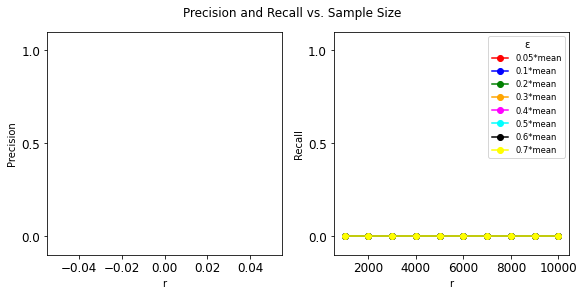

In [ ]:
mia(train_data_0, train_data_1, test_data_0, test_data_1, gen_0, gen_1, results_dir)